Лабораторна Робота № 2
Лінійна регресія


In [379]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import scipy.stats as stats
from scipy.stats import normaltest
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression

In [380]:
df = pd.read_csv('CO2 Emissions_Canada.csv')

На базі EDA проведено у 1 ЛР побудувати пайплайн препроцесингу даних [API: 1]:
(за потреби) очистити дані від рядків чи колонок, заповнити пропущені значення;
(за потреби) нормалізувати та/чи масштабувати чисельні змінні (включно з вихідною);
(за потреби) енкодувати категоріальні дані обраним методом (наприклад target-енкодування);


In [381]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

In [382]:
    Q1 = df['CO2 Emissions(g/km)'].quantile(0.25)
    Q3 = df['CO2 Emissions(g/km)'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlaier = ((df['CO2 Emissions(g/km)']<lower_bound)|(df['CO2 Emissions(g/km)']>upper_bound)).sum()
    print(outlaier)
    df = df.loc[(df['CO2 Emissions(g/km)'] >= lower_bound) & (df['CO2 Emissions(g/km)'] <= upper_bound)]
    
    outlaier = ((df['CO2 Emissions(g/km)']<lower_bound)|(df['CO2 Emissions(g/km)']>upper_bound)).sum()
    print(outlaier)


80
0


In [383]:
df.isnull().sum()

Make                                0
Model                               0
Vehicle Class                       0
Engine Size(L)                      0
Cylinders                           0
Transmission                        0
Fuel Type                           0
Fuel Consumption City (L/100 km)    0
Fuel Consumption Hwy (L/100 km)     0
Fuel Consumption Comb (L/100 km)    0
Fuel Consumption Comb (mpg)         0
CO2 Emissions(g/km)                 0
dtype: int64

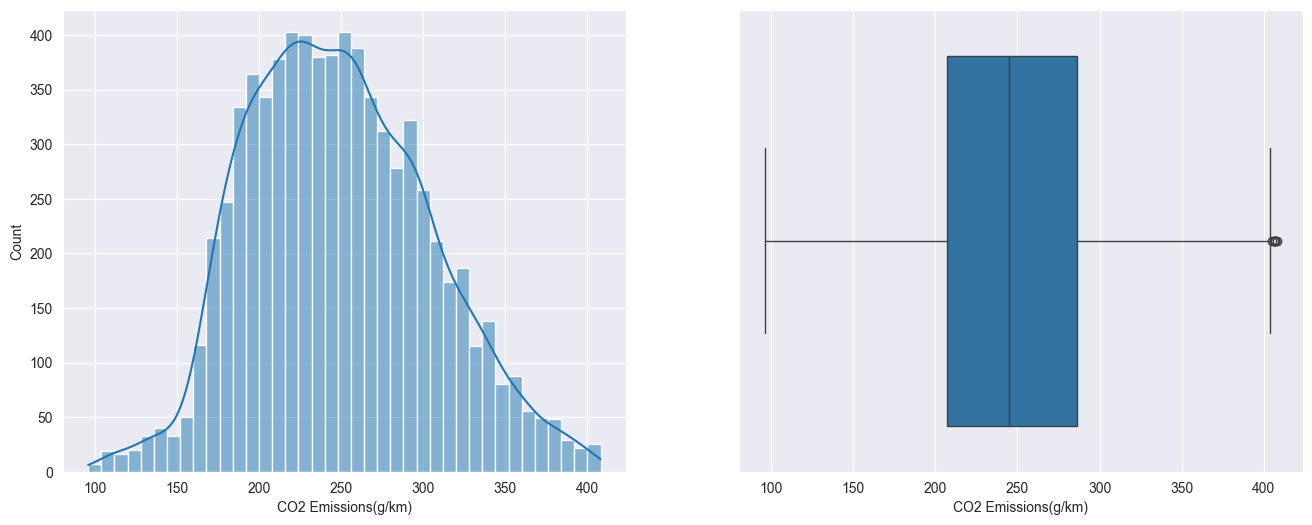

In [384]:
f , axs = plt.subplots(1,2, figsize=(16,6))
sns.histplot(data=df, x='CO2 Emissions(g/km)',kde=True, ax = axs[0])
sns.boxplot(data=df, x='CO2 Emissions(g/km)', ax= axs[1])
plt.show()

In [385]:
df = df.dropna(subset=['Fuel Type'])
df = df[df['Fuel Type'] != 'N']

In [386]:
df['Fuel Type'].unique()

array(['Z', 'D', 'X', 'E'], dtype=object)

In [387]:
df_copy = df.copy()
columns_to_encode = ['Make', 'Vehicle Class', 'Cylinders', 'Transmission', 'Fuel Type']

for column in columns_to_encode:
    binary_encoded = pd.get_dummies(df[column], prefix=column)
    df_copy = pd.concat([df_copy, binary_encoded], axis=1)
    df_copy.drop(column, axis=1, inplace=True)
    

In [388]:
df_copy.drop(columns=['CO2 Emissions(g/km)', 'Model'], inplace=True)


In [389]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7304 entries, 0 to 7384
Data columns (total 100 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Engine Size(L)                          7304 non-null   float64
 1   Fuel Consumption City (L/100 km)        7304 non-null   float64
 2   Fuel Consumption Hwy (L/100 km)         7304 non-null   float64
 3   Fuel Consumption Comb (L/100 km)        7304 non-null   float64
 4   Fuel Consumption Comb (mpg)             7304 non-null   int64  
 5   Make_ACURA                              7304 non-null   bool   
 6   Make_ALFA ROMEO                         7304 non-null   bool   
 7   Make_ASTON MARTIN                       7304 non-null   bool   
 8   Make_AUDI                               7304 non-null   bool   
 9   Make_BENTLEY                            7304 non-null   bool   
 10  Make_BMW                                7304 non-null   bool   


Розділити дані на тренувальну та тестову вибірки, “навчити” препроцесинг на тренувальній вибірці, перетворити тренувальну та тестову вибірки (див. Рекомендації щодо програмного рішення для ЛР 2, пункт 2.1.).

In [390]:
feature = df_copy
labels = df['CO2 Emissions(g/km)']

X_train, X_test, y_train, y_test = train_test_split(feature, labels, test_size = 0.2, random_state = 0)

In [391]:
print("Розмір X_train:", X_train.shape)
print("Розмір y_train:", y_train.shape)
print("Розмір X_test:", X_test.shape)
print("Розмір y_test:", y_test.shape)

Розмір X_train: (5843, 100)
Розмір y_train: (5843,)
Розмір X_test: (1461, 100)
Розмір y_test: (1461,)


In [392]:
for els in [y_train, y_test]:
    print(round(len(els)/len(labels), 2))

0.8
0.2


In [393]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Лінійна регресія

In [394]:
print("Розмір X_train_scaled:", X_train_scaled.shape)
print("Розмір y_train:", y_train.shape)
print("Розмір X_test_scaled:", X_test_scaled.shape)
print("Розмір y_test:", y_test.shape)

Розмір X_train_scaled: (5843, 100)
Розмір y_train: (5843,)
Розмір X_test_scaled: (1461, 100)
Розмір y_test: (1461,)


In [395]:
LinReg = LinearRegression()

LinReg.fit(X_train_scaled, y_train)
predictions = LinReg.predict(X_test_scaled)
r2 = LinReg.score(X_test_scaled, y_test)
print("score:", r2)

score: 0.9930665525069515


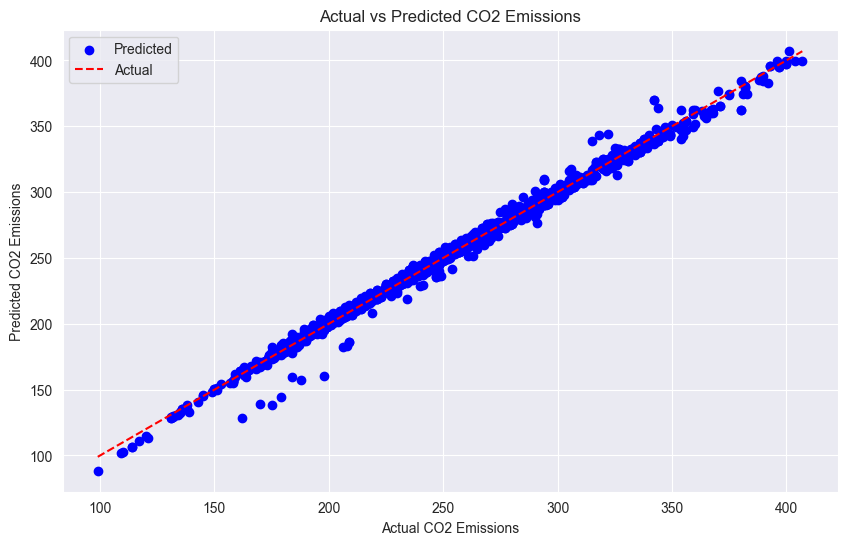

In [396]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, color='blue', label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', label='Actual')
plt.title('Actual vs Predicted CO2 Emissions')
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Predicted CO2 Emissions')
plt.legend()
plt.show()

In [397]:
coefficients = LinReg.coef_
feature_names = feature.columns
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
print(coefficients_df)


coefficients_df['Absolute Coefficient'] = np.abs(coefficients_df['Coefficient'])
sorted_coefficients = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)
print("sorted_coefficients")
print(sorted_coefficients)

                             Feature   Coefficient
0                     Engine Size(L)  4.250145e-01
1   Fuel Consumption City (L/100 km)  2.057813e+01
2    Fuel Consumption Hwy (L/100 km)  1.184312e+01
3   Fuel Consumption Comb (L/100 km)  2.345232e+01
4        Fuel Consumption Comb (mpg) -5.954222e+00
..                               ...           ...
95                   Transmission_M7 -7.937480e+10
96                       Fuel Type_D -6.964462e+11
97                       Fuel Type_E -9.755956e+11
98                       Fuel Type_X -2.245902e+12
99                       Fuel Type_Z -2.224384e+12

[100 rows x 2 columns]
sorted_coefficients
                             Feature   Coefficient  Absolute Coefficient
63                       Cylinders_4 -5.880854e+12          5.880854e+12
65                       Cylinders_6 -5.577933e+12          5.577933e+12
66                       Cylinders_8 -4.605004e+12          4.605004e+12
98                       Fuel Type_X -2.245902e+12  

Обчислити лишки на тестовій вибірці, провести аналіз лишків (нормальність розподілу, незалежність від вихідної змінної) 

In [398]:
residuals = y_test - predictions


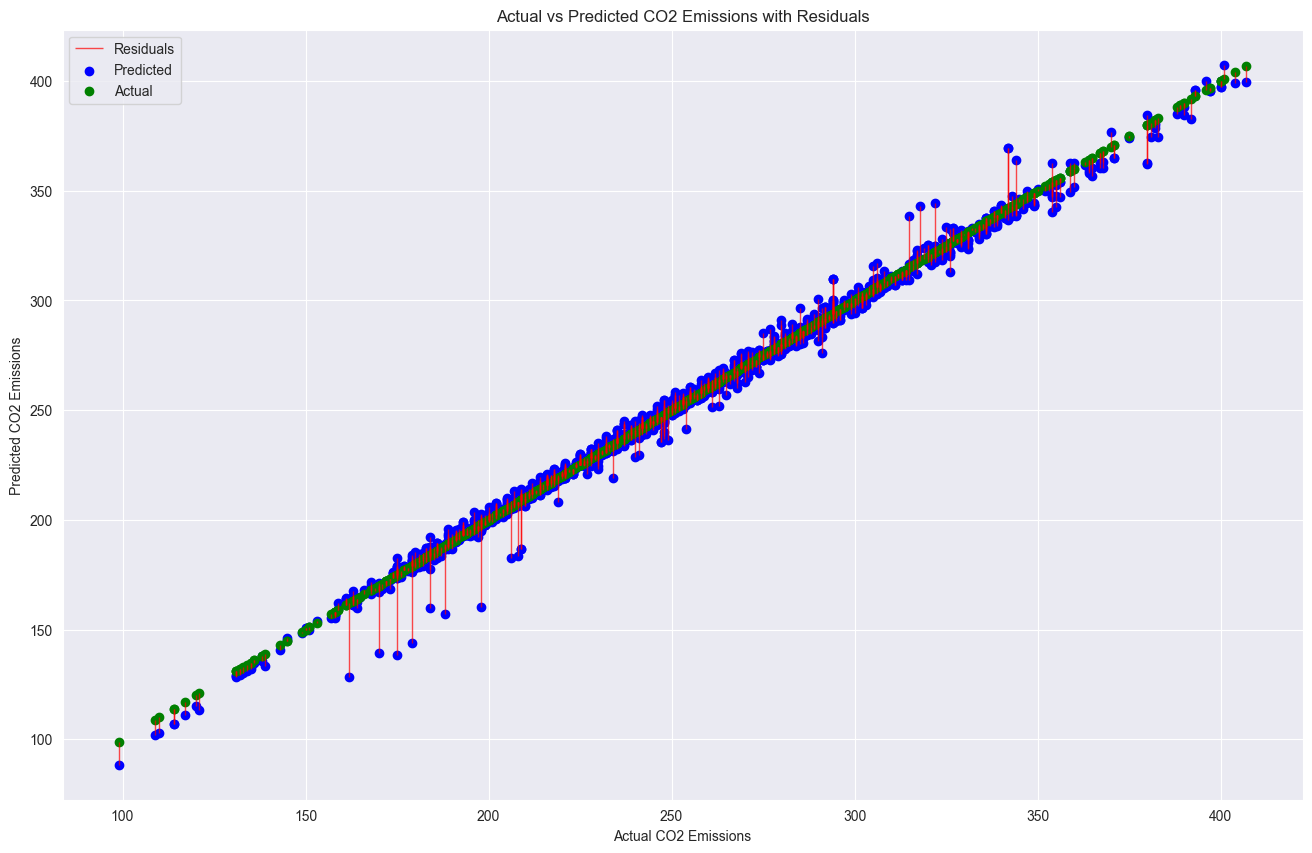

In [399]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.vlines(y_test, predictions, predictions + residuals, colors='red', alpha=0.7, linewidth=1, label='Residuals')
ax.scatter(y_test, predictions, color='blue', label='Predicted')
ax.scatter(y_test, y_test, color='green', label='Actual')

ax.set_xlabel('Actual CO2 Emissions')
ax.set_ylabel('Predicted CO2 Emissions')
ax.set_title('Actual vs Predicted CO2 Emissions with Residuals')
ax.legend()
plt.grid(True)
plt.show()


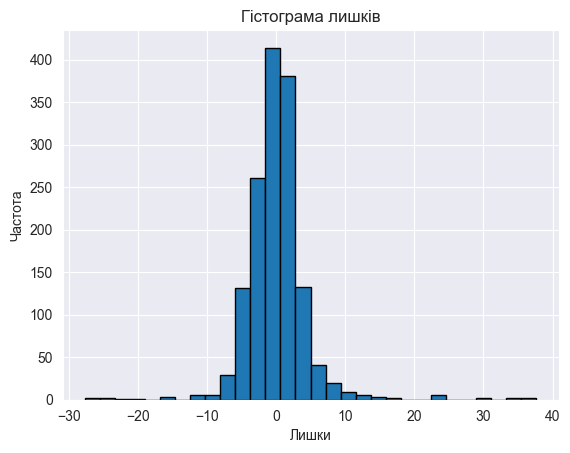

In [400]:
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Гістограма лишків')
plt.xlabel('Лишки')
plt.ylabel('Частота')
plt.show()

In [401]:
stat, p_value = normaltest(residuals)
print(f"Статистика тесту: {stat}, p-value: {p_value}")

# Якщо p-value менше вибраного рівня значимості (наприклад, 0.05), то відхиляємо нульову гіпотезу про нормальність розподілу
if p_value < 0.05:
    print("Розподіл лишків не є нормальним")
else:
    print("Розподіл лишків є нормальним")

Статистика тесту: 710.050684394653, p-value: 6.523083651074896e-155
Розподіл лишків не є нормальним


Навчити модель на 3 відібраних вхідних змінних (на базі коефіцієнта кореляції, MI чи оцінці розподілі за категоріями проведеними в EDA), обчислити метрики на тестовій вибірці;

In [402]:
print(df.columns)


Index(['Make', 'Model', 'Vehicle Class', 'Engine Size(L)', 'Cylinders',
       'Transmission', 'Fuel Type', 'Fuel Consumption City (L/100 km)',
       'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
       'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)'],
      dtype='object')


In [403]:
X_train_selected = X_train[['Engine Size(L)', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)']]
X_test_selected = X_test[['Engine Size(L)', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)']]


In [404]:
model_selected = LinearRegression()
model_selected.fit(X_train_selected, y_train)

LinearRegression()

In [405]:
predictions_selected = model_selected.predict(X_test_selected)

mae_select = mean_absolute_error(y_test, predictions_selected)
mse_select  = mean_squared_error(y_test, predictions_selected)
r_squared_select  = r2_score(y_test, predictions_selected)
print("Mean Absolute Error (MAE):", mae_select)
print("Mean Squared Error (MSE):", mse_select)
print("R²:", r_squared_select)

Mean Absolute Error (MAE): 12.98487848989438
Mean Squared Error (MSE): 390.8034162590398
R²: 0.8687612677531052


обчислити метрики на тестовій вибірці; для звичайної лін моделі


In [406]:

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r_squared = r2_score(y_test, predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R²:", r_squared)

Mean Absolute Error (MAE): 2.7993020659929546
Mean Squared Error (MSE): 20.646457949917846
R²: 0.9930665525069515


(для СА-33) Навчити модель на топ-3 відібраних вхідних змінних визначених з допомогою SelectKBest, обчислити метрики на тестовій вибірці;

In [407]:
selector = SelectKBest(score_func=f_regression, k=3)
X_train3 = selector.fit_transform(X_train_scaled, y_train)
X_test3 = selector.transform(X_test_scaled)
model3 = LinearRegression()
model3.fit(X_train3, y_train)

predictions3 = model3.predict(X_test3)
mae3 = mean_absolute_error(y_test, predictions3)
mse3 = mean_squared_error(y_test, predictions3)
r_squared3= r2_score(y_test, predictions3)

print("mae3", mae3)
print("Mean Squared Error (MSE) for top-3 selected features:", mse3)
print("R² for top-3 selected features:", r_squared3)

mae3 12.577699398181203
Mean Squared Error (MSE) for top-3 selected features: 409.0283840150436
R² for top-3 selected features: 0.8626409997000924


Побудувати модель L1-регуляризованої лінійної регресії Lasso

Навчити модель Lasso-регресії (на всіх змінних);

In [408]:
lasso_model = linear_model.Lasso(alpha=1.0, max_iter=10000) 
lasso_model.fit(X_train_scaled, y_train)
r2_l = lasso_model.score(X_test_scaled, y_test)
print("coef:", r2_l)


coef: 0.9908388571769199


In [409]:
lasso_model = linear_model.Lasso(max_iter=10000) 
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(lasso_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)


GridSearchCV(cv=5, estimator=Lasso(max_iter=10000),
             param_grid={'alpha': [0.1, 1.0, 10.0, 100.0]})

In [410]:
best_alpha = grid_search.best_params_['alpha']
lasso_tuned = linear_model.Lasso(alpha=best_alpha)
lasso_tuned.fit(X_train_scaled, y_train)
r2_t = lasso_tuned.score(X_test_scaled, y_test)
print("Best Alpha:", best_alpha)
print("coef:", r2_t)


Best Alpha: 0.1
coef: 0.9929286796861732


In [411]:
predictions_lasso = lasso_tuned.predict(X_test_scaled)
mae_lasso = mean_absolute_error(y_test, predictions_lasso)
mse_lasso = mean_squared_error(y_test, predictions_lasso)
r2_lasso = r2_score(y_test, predictions_lasso)

print("mean_absolute_error (MAE):", mae_lasso)
print("Mean Squared Error (MSE):", mse_lasso)
print("Coefficient of Determination (R^2):", r2_lasso)

mean_absolute_error (MAE): 2.8275813509871948
Mean Squared Error (MSE): 21.05701639136988
Coefficient of Determination (R^2): 0.9929286796861732


In [420]:
coefficients_lasso = lasso_tuned.coef_ 
print(coefficients_lasso)

feature_names = X_train.columns.tolist()
coefficients_lasso = lasso_tuned.coef_
coefficients_lasso_df = pd.DataFrame({'Feature': feature_names, 'Coefficient (Lasso)': coefficients_lasso})
print(coefficients_lasso_df)


coefficients_lasso_df['Absolute Coefficient'] = np.abs(coefficients_lasso_df['Coefficient (Lasso)'])
sorted_coefficients_lasso = coefficients_lasso_df.sort_values(by='Absolute Coefficient', ascending=False)
print("sorted_coefficients_lasso")
print(sorted_coefficients_lasso)

[ 1.48423388e+00  3.13217475e+01  1.73651477e+01  7.39076929e+00
 -5.69337789e+00 -4.90307900e-02  0.00000000e+00  2.25966320e-02
 -0.00000000e+00  1.70174532e-01 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  2.05964653e-01  1.76154398e-01
 -0.00000000e+00  2.90497447e-01  1.28824909e-01 -0.00000000e+00
 -0.00000000e+00  6.33589863e-02 -0.00000000e+00  0.00000000e+00
  2.21363251e-02  2.87319873e-03  5.78973358e-02 -0.00000000e+00
 -6.83343508e-02  4.58363775e-02  3.09339298e-01 -1.08487707e-01
 -0.00000000e+00 -3.95038253e-02 -3.04527838e-02  0.00000000e+00
 -0.00000000e+00  4.47534484e-02  7.13006256e-02 -8.79948129e-03
 -0.00000000e+00 -0.00000000e+00 -6.58002934e-03  0.00000000e+00
 -9.69069262e-02 -5.10926653e-02 -6.03610483e-03  1.35408038e-01
 -0.00000000e+00 -1.26092760e-01  0.00000000e+00  2.56970569e-01
  1.70116297e-01  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -3.46701416e-02 -0.00000000e+00  2.53780883e-01  0.00000000e+00
 -5.20942072e-01 -2.62730

Навчити модель L2-регуляризованої лінійної регресії Ridge [API: 4]
Навчити модель Ridge-регресії (на всіх змінних) з тюнингом гіперпаратмерів, аналогічному до виконаного у Lasso-регресії;


In [413]:
ridge_model = Ridge()
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
random_search_ridge = RandomizedSearchCV(ridge_model, param_distributions=param_grid, n_iter=4, cv=5)
random_search_ridge.fit(X_train_scaled, y_train)
ridge_tuned = random_search_ridge.best_estimator_
print("Best alpha:", ridge_tuned.alpha)
print("Coefficients:", ridge_tuned.coef_)

Best alpha: 1.0
Coefficients: [ 4.36060544e-01  2.18041550e+01  1.25782278e+01  2.13885759e+01
 -6.02533614e+00 -2.79663641e-01 -3.39647893e-02  6.34774646e-02
 -3.42101835e-01  1.69322776e-01 -3.71370237e-01  2.94068660e-03
 -1.23377668e-01  2.37219445e-01  4.51413985e-01  5.02098018e-01
  2.93189509e-02  4.42316629e-01  1.67328987e-01  1.32251496e-01
 -2.22284300e-02  2.15052079e-01 -1.15940263e-01 -1.77787879e-01
  2.15871207e-01  1.67325656e-01 -1.52534383e-02 -2.79757706e-01
 -2.10993896e-01  1.86192640e-01  2.63091135e-01 -8.44206207e-02
 -2.77026892e-01 -2.58304664e-01 -1.46776385e-01  4.44034515e-02
 -3.06771034e-01  2.19366623e-01  1.24914626e-01 -6.94841252e-02
 -2.20568148e-01 -1.02515916e-02 -5.19427303e-02  1.18691472e-01
 -2.16441188e-01 -2.21964359e-01 -7.06704035e-02  7.81047719e-02
 -1.25919320e-01 -2.42203951e-01 -3.09837022e-02  3.97620715e-01
  2.21802047e-01  1.31156444e-02  6.32246045e-03 -3.86479466e-02
 -1.61891248e-01 -5.54011399e-02  3.86933107e-01 -1.32152253

In [414]:
predictions_ridge = ridge_tuned.predict(X_test_scaled)
mae_ridge = mean_absolute_error(y_test, predictions_ridge)
mse_ridge = mean_squared_error(y_test, predictions_ridge)
r2_ridge = r2_score(y_test, predictions_ridge)


print("MAE:", mae_ridge)
print("Mean Squared Error (MSE):", mse_ridge)
print("Coefficient of Determination (R^2):", r2_ridge)

MAE: 2.8024341957926833
Mean Squared Error (MSE): 20.611797905986336
Coefficient of Determination (R^2): 0.9930781919656562


Обчислити лишки на тестовій вибірці, провести аналіз лишків (нормальність розподілу, незалежність від вихідної змінної) [API: 6];

5778     1.282882
6467     1.303391
996     -3.870639
6434     0.911343
3728    14.783835
          ...    
1912    -2.774724
5764    -1.987536
413     -3.639810
2571    -0.061001
7006    -0.300064
Name: CO2 Emissions(g/km), Length: 1461, dtype: float64


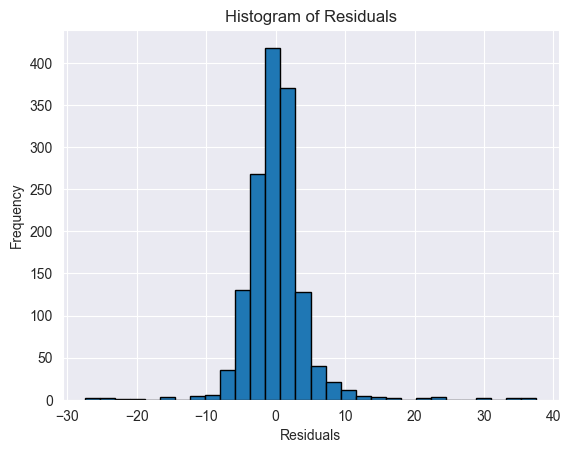

In [421]:
residuals = y_test - predictions_ridge
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


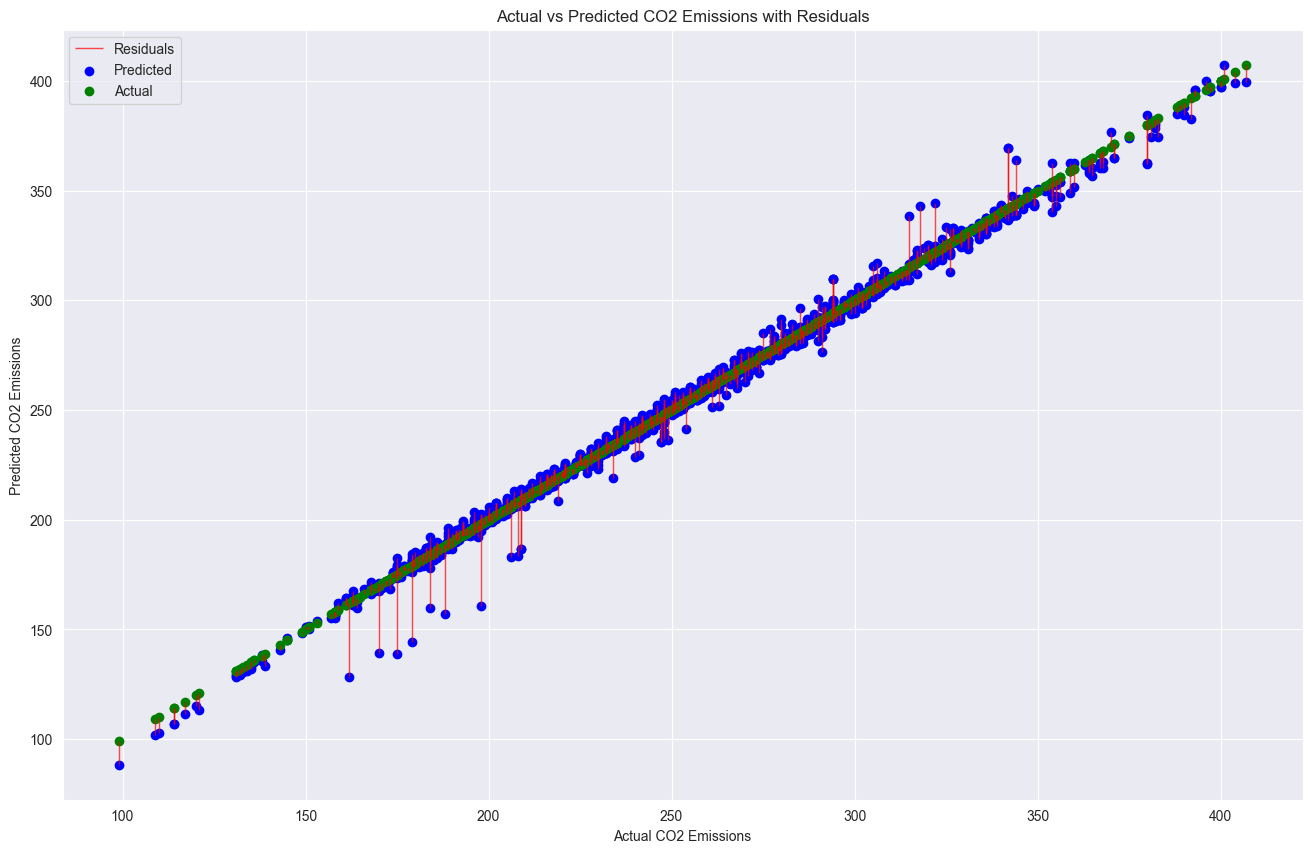

In [416]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.vlines(y_test, predictions_ridge, predictions_ridge + residuals, colors='red', alpha=0.7, linewidth=1, label='Residuals')
ax.scatter(y_test, predictions_ridge, color='blue', label='Predicted')
ax.scatter(y_test, y_test, color='green', label='Actual')

ax.set_xlabel('Actual CO2 Emissions')
ax.set_ylabel('Predicted CO2 Emissions')
ax.set_title('Actual vs Predicted CO2 Emissions with Residuals')
ax.legend()
plt.grid(True)
plt.show()


Вивести порівняльну таблицю для чотирьох моделей по всім заданим метрикам, зробити відповідні висновки.

In [417]:
models_metrics = {
    'Model': ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Selected Features'],
    'MAE': [mae, mae_lasso, mae_ridge, mae3],
    'MSE': [mse, mse_lasso, mse_ridge, mse3],
    'R²': [r_squared, r2_lasso, r2_ridge, r_squared3]
}
metrics_df = pd.DataFrame(models_metrics)
# Виведення порівняльної таблиці
print(metrics_df)


               Model        MAE         MSE        R²
0  Linear Regression   2.799302   20.646458  0.993067
1   Lasso Regression   2.827581   21.057016  0.992929
2   Ridge Regression   2.802434   20.611798  0.993078
3  Selected Features  12.577699  409.028384  0.862641


Точне і узгоджене все, але Лінійна регресія більше (крім 4)